In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import os
import json
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import torch.optim as optim


competition = 'asl-signs'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

plt.style.use("ggplot")

In [2]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('..') / 'input'  / 'competition'
    # !pip install -Uqq fastai
else:
    import zipfile, kaggle
    path = Path.home() / '.data' / 'asl-signs'
    if not path.exists():
        path.mkdir(exist_ok=True)
        kaggle.api.competition_download_cli(competition, path=path)
        zipfile.ZipFile(path / f'{competition}.zip').extractall(path)

# Labeled Data

In [3]:
with open(path / 'sign_to_prediction_index_map.json') as f:
    sign_labels = json.load(f)

In [4]:
train = (pd.read_csv(path / 'train_with_meta.csv')
         .assign(idx=lambda x: x.participant_id.astype(str) + '_' + x.sequence_id.astype(str))
         .set_index('idx')
        )



# signs_subset = ['TV', 'because', 'duck', 'balloon',
#                 'boy', 'fish',  'thankyou', 'underwear'
#                ]
signs_subset = train.sign.drop_duplicates().sample(50, random_state=69).tolist()
train = train.loc[train.sign.isin(signs_subset)]

sign_labels = {sign: i for i, sign in enumerate(signs_subset)}

print(', '.join(signs_subset))

fast, tiger, look, that, please, water, yes, table, say, penny, snack, better, tooth, morning, eye, toothbrush, hello, car, vacuum, taste, mitten, radio, flower, quiet, goose, frenchfries, red, white, noisy, kitty, hide, dance, milk, pencil, up, bug, chair, toy, cut, dry, minemy, frog, glasswindow, weus, for, like, grandma, stay, carrot, nuts


In [5]:
# this record doesn't have any frames
train = train.loc[train.index != '55372_2067021052', :]

### Removing records with <=3 hand frames

In [6]:
(train.groupby(train.loc[:, ['left_hand', 'right_hand']].max(axis=1) <= 3)
 .size()
)

False    17021
True      1914
dtype: int64

In [7]:
mask = train.loc[:, ['left_hand', 'right_hand']].max(axis=1) > 3
train = train.loc[mask, :]
train.shape

(17021, 11)

# Competition Data Loader

In [8]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

# Data Loader

In [9]:
class ASLRecord:
    POSE_LANDMARK_INDICES = [23, 11, 13, 15, 24, 12, 14, 16]
    def __init__(self, record_id):
        self.record_id = record_id
        self.record = train.loc[self.record_id, :]

        self.landmarks = pd.read_parquet(path / self.record['path'])
    
    @property
    def hand(self):
        # determine which hand has more frames
        return self.record[['left_hand', 'right_hand']].astype(float).idxmax()
    
    def transform_landmarks(self):
        landmarks_trans = self.landmarks
        
        landmarks_trans = self.filter_types(landmarks_trans)
        
        landmarks_trans = self.flip_left_hand(landmarks_trans)
        
        landmarks_trans = self.filter_landmark_indices(landmarks_trans)
        
        # landmarks_trans = self.interpolate_values(landmarks_trans)
        
        landmarks_trans = self.drop_frames_with_nas(landmarks_trans)
        
        landmarks_trans = self.pivot(landmarks_trans)
        
        landmarks_trans = self.to_tensor(landmarks_trans)
        
        return landmarks_trans
    
    def filter_types(self, landmarks):
        # filter for hand with more frames and pose
        landmark_types = ['pose', self.hand]
        type_mask = landmarks.type.isin(landmark_types)
        landmarks = landmarks.loc[type_mask, :]
        return landmarks
        
    def flip_left_hand(self, landmarks):
        # flip left hand if necessary
        if self.hand == 'left_hand':
            left_hand_mask = landmarks.loc[:, 'type'] == 'left_hand'
            landmarks.loc[left_hand_mask, 'x'] = -landmarks.loc[left_hand_mask, 'x']
            
            pose_mask = landmarks.loc[:, 'type'] == 'pose'
            landmarks.loc[pose_mask, 'x'] = -landmarks.loc[pose_mask, 'x']
        return landmarks
    
    def filter_landmark_indices(self, landmarks):
        # drop all pose landmarks except necessary ones
        mask = ((landmarks.type == self.hand) | 
                ((landmarks.type == 'pose') & (landmarks.landmark_index.isin(self.POSE_LANDMARK_INDICES)))
               )
        landmarks = landmarks.loc[mask, :]
        return landmarks
    
    def interpolate_values(self, landmarks):
        inter_dims = ['type', 'landmark_index']
        landmarks = (landmarks.sort_values(['type', 'landmark_index', 'frame'])
                     .assign(x=lambda x: x.groupby(inter_dims).x.apply(lambda g: g.interpolate()),
                             y=lambda x: x.groupby(inter_dims).y.apply(lambda g: g.interpolate()),
                             z=lambda x: x.groupby(inter_dims).z.apply(lambda g: g.interpolate()),
                      )
                    )
        return landmarks
    
    def drop_frames_with_nas(self, landmarks):
        na_mask = landmarks.loc[:, ['x', 'y', 'z']].isna().any(axis=1)
        na_frames = landmarks.loc[na_mask, 'frame'].unique().tolist()

        na_frames_mask = landmarks.loc[:, 'frame'].isin(na_frames)
        landmarks = landmarks.loc[~na_frames_mask, :]
        return landmarks
    
    
    def pivot(self, landmarks):
        n_frames = landmarks.frame.nunique()
        n_landmarks = landmarks[['type', 'landmark_index']].drop_duplicates().shape[0]
        landmarks = landmarks[['x', 'y', 'z']].values.reshape(n_frames, n_landmarks, 3)
        
        landmarks = landmarks.reshape(n_frames, -1)
        
        return landmarks
    
    def to_tensor(self, landmarks):
        return torch.from_numpy(landmarks).float()
        
        
    

# record = ASLRecord('61333_1002052130')
# record.transform_landmarks().shape

In [10]:
n = len(train)
# n = 10
errors = list()
records = dict()
for i in tqdm(range(n)):
    record = train.iloc[i]
    record_id = record.name
    try:
        records[record_id] = ASLRecord(record_id).transform_landmarks()
    except Exception as e:
        errors.append([record.name, type(e)])
errors

  0%|          | 0/17021 [00:00<?, ?it/s]

[]

In [11]:
class ASLDataset(Dataset):
    SIGN_LABELS = sign_labels
    SIGN_LABELS_INV = {v: k for k, v in sign_labels.items()}
    
    def __init__(self, df_record_meta):
        self.df_record_meta = df_record_meta
    
    def __len__(self):
        return len(self.df_record_meta)
    
    def __getitem__(self, idx):
        record = self.df_record_meta.iloc[idx, :]
        record_id = record.name
        
        sign_name = record['sign']
        sign_idx = self.SIGN_LABELS[sign_name]
        sign_tensor = torch.tensor([sign_idx], dtype=torch.long).cuda()
        
        # landmarks = ASLRecord(record_id).transform_landmarks()
        landmarks = records[record_id].cuda()
        
        return landmarks, sign_tensor
    
    
def collate_fn(batch):
    len_func = lambda x: x.shape[0]
    landmark_vectors, signs_vec, lengths = zip(*[
        (landmarks, sign_num, len_func(landmarks))
        for landmarks, sign_num in sorted(batch, key=lambda x: len_func(x[0]), reverse=True)
    ])
    
    signs_vec = torch.LongTensor(signs_vec)
    lengths = torch.LongTensor(lengths)
    
    padded_sequence_vectors = pad_sequence(landmark_vectors, batch_first=True, padding_value=0)
    
    # pack_padded_sequence_vectors = pack_padded_sequence(padded_sequence_vectors, lengths.cpu(), batch_first=True)
    
    return padded_sequence_vectors, signs_vec

In [26]:
training_set, test_set = train_test_split(train, test_size=0.2,
                                          random_state=42, stratify=train.sign)

train_dataset = ASLDataset(training_set)
train_dataloader = DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)

test_dataset = ASLDataset(test_set)
test_dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn, shuffle=False, drop_last=False)

batch_features, batch_labels = next(iter(train_dataloader))
landmarks_tensor, sign_tensor = batch_features, batch_labels
# landmarks_tensor, sign_tensor

In [27]:
test_set.groupby('sign')[['sequence_id', 'participant_id']].nunique().T

sign,better,bug,car,carrot,chair,cut,dance,dry,eye,fast,...,tiger,tooth,toothbrush,toy,up,vacuum,water,weus,white,yes
sequence_id,62,74,59,74,60,63,40,73,75,64,...,75,74,75,70,73,45,73,65,66,70
participant_id,21,20,18,21,19,20,19,20,20,20,...,21,21,19,19,21,17,19,20,21,20


# Creating the network

In [28]:
def categoryFromOutput(output):
    category_val, category_i = output.topk(1, dim=1)
    category_i = category_i[:, 0].tolist()
    return [sign_labels_inv[i] for i in category_i]

sign_labels_inv = {v: k for k, v in sign_labels.items()}

# Preparing the Network

In [29]:
class ASLLSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, **lstm_kwargs):
        super(ASLLSTM, self).__init__()

        self.hidden_dim = 512

        self.lstm = nn.LSTM(input_size, 512, batch_first=True, **lstm_kwargs)
        
        self.dropout = nn.Dropout(0.25)
        
        self.dense_1 = nn.Linear(512, 256)
        
        self.act_1 = nn.ReLU()
        
        self.dense_2 = nn.Linear(256, 128)
        
        self.act_2 = nn.ReLU()
        
        self.dense_3 = nn.Linear(64, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, landmarks):
        lstm_out, _ = self.lstm(landmarks)
        # lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        X = self.dropout(lstm_out[:, -1, :])
        
        X = self.dense_1(X)
        X = self.act_1(X)
        
        X = self.dropout(X)
        X = self.dense_2(X)
        X = self.act_2(X)
        
        X = self.dropout(X)
        X = self.dense_3(X)
        
        return self.softmax(X)

## Training the Network

In [30]:
n_categories = len(sign_labels)
input_size = 87
model = ASLLSTM(input_size, n_categories)
model.to(device)

epochs = 80

loss_fn = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.01,step_size_up=5,mode="exp_range",gamma=0.85)

training_losses = list()
test_losses = list()
test_accuracies = list()

for epoch in range(epochs):
    training_loss = 0
    for batch_features, batch_labels in train_dataloader:
        model.zero_grad()
        
        output = model(batch_features)
        
        loss = loss_fn(output, batch_labels.cuda())
        loss.backward()
        training_loss += loss * batch_labels.shape[0]
        
        optimizer.step()
    
    lr = optimizer.param_groups[0]["lr"]
    scheduler.step()

    training_loss = int(training_loss) / len(train_dataset)
    training_losses.append(training_loss)

    # testing
    guesses = list()
    test_loss = 0

    for batch_features, batch_labels in test_dataloader:
        with torch.no_grad():
            output = model(batch_features)

            test_loss += loss_fn(output, batch_labels.cuda()) * batch_labels.shape[0]

            guess = categoryFromOutput(output)
            guesses.extend(guess)
    
    test_loss = int(test_loss) / len(test_dataset)
    test_losses.append(test_loss)
    
    test_accuracy = accuracy_score(test_set.sign, guesses)
    test_accuracies.append(test_accuracy)
    
    training_loss_delta = training_losses[-1] - training_losses[0]
    test_loss_delta = test_losses[-1] - test_losses[0]
    
    print(f"Epoch #{epoch:2.0f} (LR {lr:0.8f}):    "
          f"Training Loss: {training_loss:2.2f} (Δ{test_loss_delta:2.2f})    "
          f"Test Loss: {test_loss:2.2f} (Δ{test_loss_delta:2.2f})   "
          f"Test Accuracy: {test_accuracy:.0%}")

Epoch # 0 (LR 0.01000000):    Training Loss: 3.91    Test Loss: 3.91    Test Accuracy: 2%
Epoch # 1 (LR 0.00950000):    Training Loss: 3.85    Test Loss: 3.73    Test Accuracy: 4%
Epoch # 2 (LR 0.00902500):    Training Loss: 3.69    Test Loss: 3.62    Test Accuracy: 5%
Epoch # 3 (LR 0.00857375):    Training Loss: 3.59    Test Loss: 3.50    Test Accuracy: 9%
Epoch # 4 (LR 0.00814506):    Training Loss: 3.40    Test Loss: 3.31    Test Accuracy: 10%
Epoch # 5 (LR 0.00773781):    Training Loss: 3.19    Test Loss: 3.33    Test Accuracy: 11%
Epoch # 6 (LR 0.00735092):    Training Loss: 3.02    Test Loss: 2.97    Test Accuracy: 16%
Epoch # 7 (LR 0.00698337):    Training Loss: 2.87    Test Loss: 2.76    Test Accuracy: 20%
Epoch # 8 (LR 0.00663420):    Training Loss: 2.73    Test Loss: 2.67    Test Accuracy: 24%
Epoch # 9 (LR 0.00630249):    Training Loss: 2.60    Test Loss: 2.63    Test Accuracy: 25%
Epoch #10 (LR 0.00598737):    Training Loss: 2.48    Test Loss: 2.45    Test Accuracy: 29%
Epo

In [36]:
df_losses = (pd.concat([pd.Series(index=range(epochs), data=training_losses, name="Training Set"),
                        pd.Series(index=range(1, epochs+1), data=test_losses, name="Test Set")
                       ], axis=1)
             .unstack()
             .reset_index()
            )
df_losses.columns = ['Set', 'Epoch', 'Loss']

test_set.loc[:, 'prediction'] = guesses

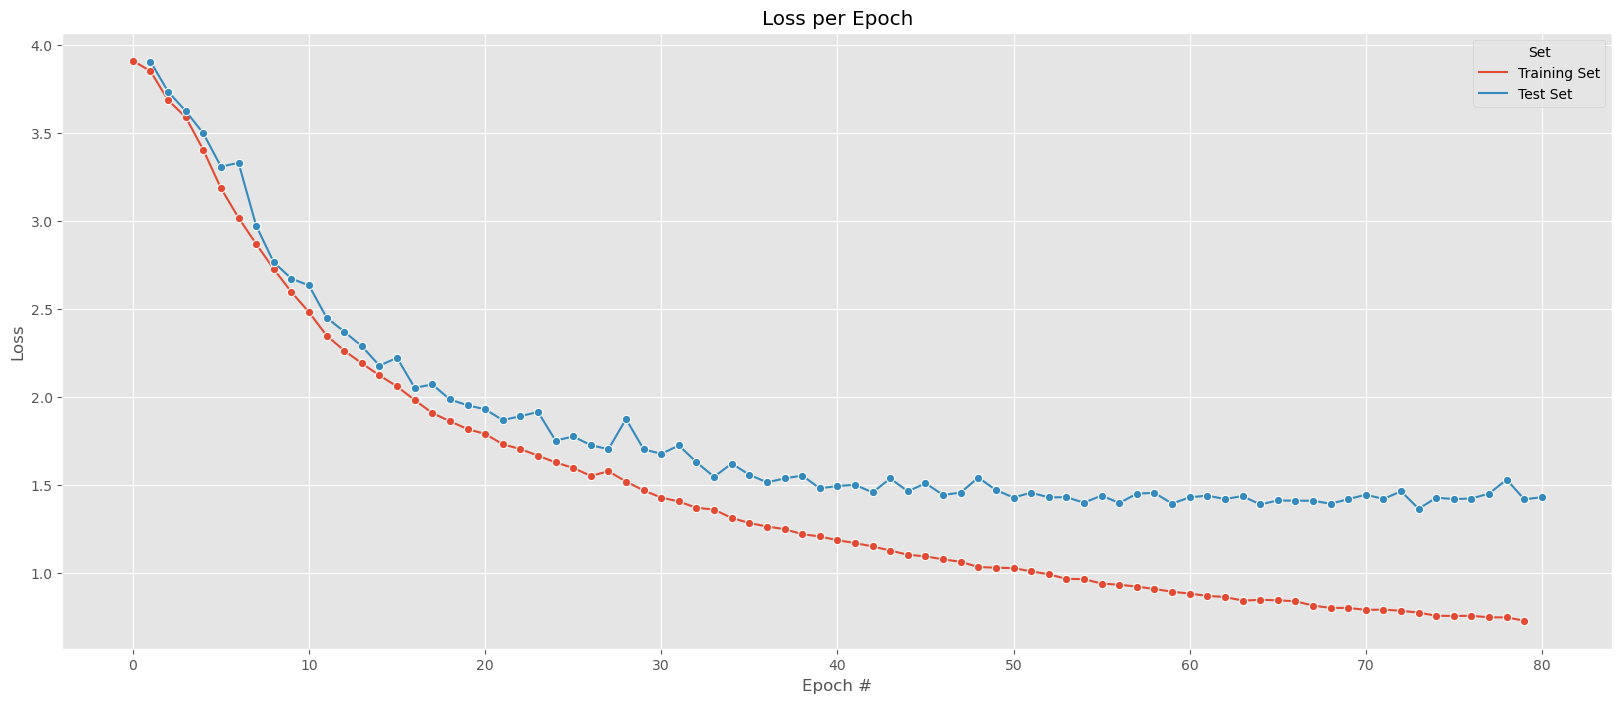

In [48]:
def plot_losses_per_epoch(ax=None, fig=None, for_pdf=None):
    if fig is None:
        fig, ax = plt.subplots(figsize=(20, 8))

    sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Set', marker='o')
    ax.set(title="Loss per Epoch", xlabel="Epoch #", ylabel="Loss")
    
    if for_pdf:
        return fig, ax
    else:
        plt.show()

plot_losses_per_epoch()

# Error Analysis

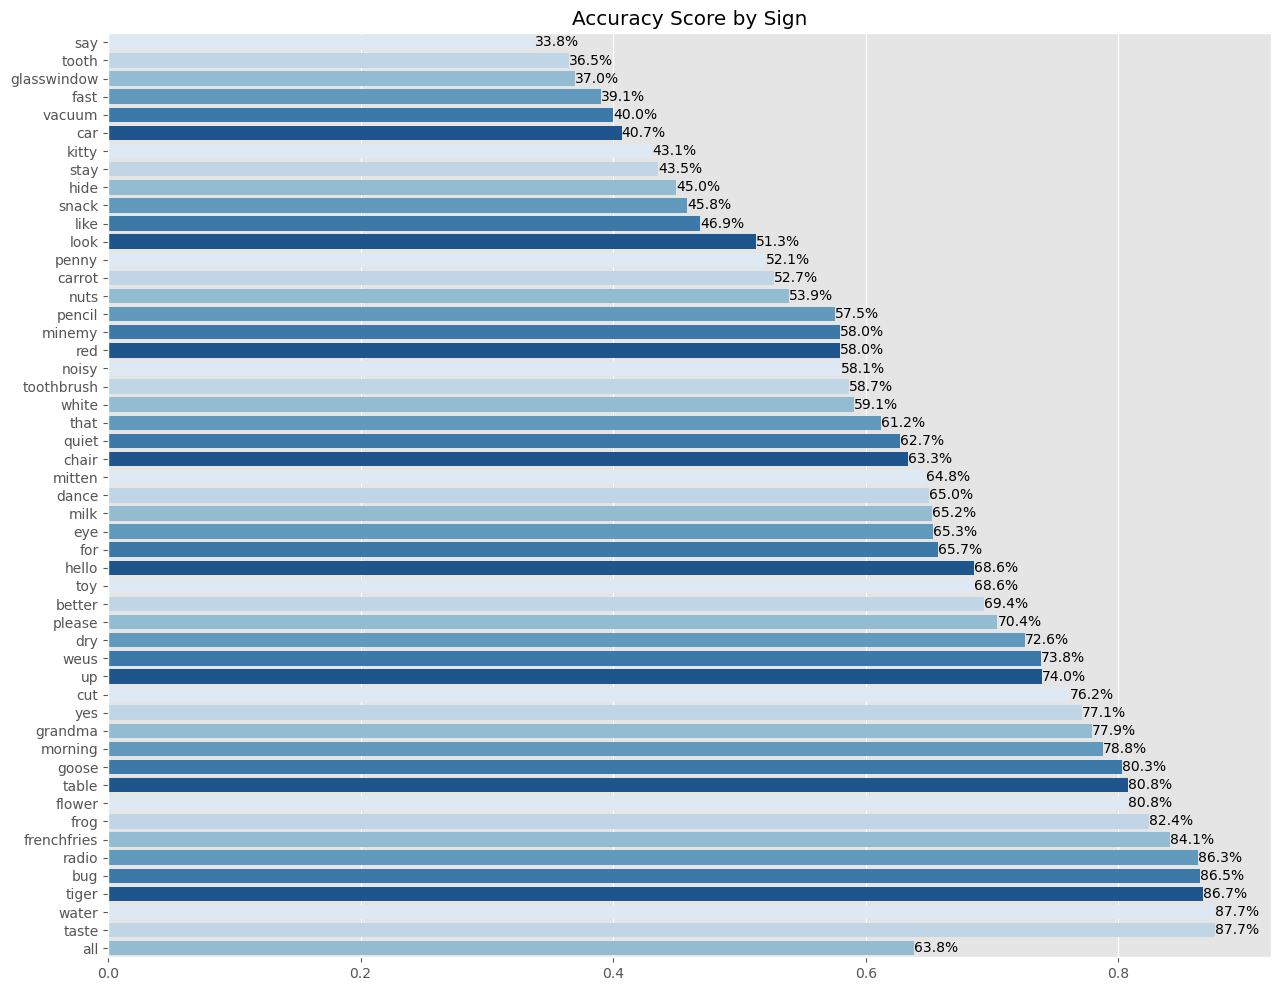

In [49]:
def plot_accuracy_score_by_sign(fig=None, ax=None, for_pdf=False):
    accuracy_scores = (pd.DataFrame(pd.concat([
        test_set.groupby('sign').apply(lambda x: accuracy_score(x.sign, x.prediction)).sort_values(),
        pd.Series({'all': accuracy_score(test_set.sign, test_set.prediction)})
    ]))
     .reset_index()
     .rename(columns={'index': 'Sign', 0: 'Accuracy'})
    )
    
    if fig is None:
        fig, ax = plt.subplots(figsize=(15, 12))
        
    ax = sns.barplot(data=accuracy_scores, y='Sign', x='Accuracy', ax=ax, palette=sns.color_palette('Blues'))
    ax.set(title='Accuracy Score by Sign', xlabel='', ylabel='')

    for i in ax.containers:
        ax.bar_label(i, [f'{j:.1%}' for j in i.datavalues])

    if for_pdf:
        return fig, ax
    else:
        plt.show()
        
        
plot_accuracy_score_by_sign()

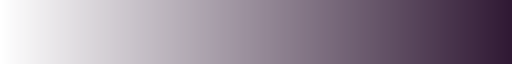

In [55]:
sns.color_palette('blend:#fff,#301934', as_cmap=True)

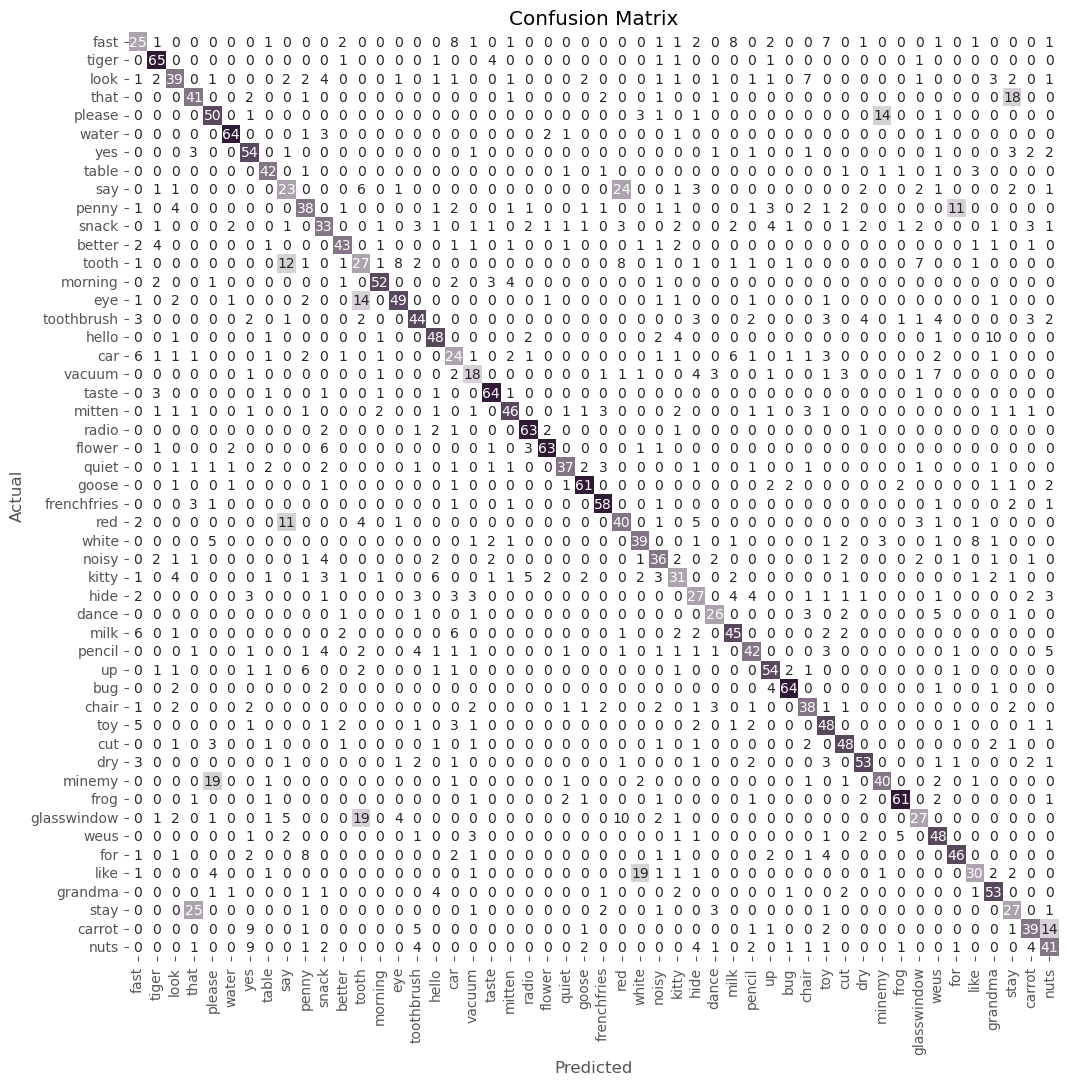

In [56]:
def plot_confusion_matrix(fig=None, ax=None, for_pdf=False):
    cf_matrix = confusion_matrix(test_set.sign, test_set.prediction, labels=signs_subset)

    if fig is None:
        fig, ax = plt.subplots(figsize=(12, 12))
        
    sns.heatmap(cf_matrix, annot=True, 
                cmap=sns.color_palette('blend:#fff,#301934'), 
                cbar=False, ax=ax,
                xticklabels=signs_subset, yticklabels=signs_subset)
    ax.set(title="Confusion Matrix", xlabel="Predicted", ylabel="Actual")

    if for_pdf:
        return fig, ax
    else:
        plt.show()

plot_confusion_matrix()      

## PDF

In [59]:
model_number = input()
filepath = path / 'model_pdfs' / f'model_{model_number}.pdf'
with PdfPages(filepath) as pdf:
    fig, ax = plot_losses_per_epoch(for_pdf=True)
    pdf.savefig(fig)
    plt.close()
    
    fig, ax = plot_accuracy_score_by_sign(for_pdf=True)
    pdf.savefig(fig)
    plt.close()
    
    fig, ax = plot_confusion_matrix(for_pdf=True)
    pdf.savefig(fig)
    plt.close()

23


In [60]:
test_error_mask = test_set.sign != test_set.prediction
cols = ['sign', 'prediction', 'total_frames', 'left_hand', 'right_hand']
test_errors = test_set.loc[test_error_mask, cols]
test_errors

,sign,prediction,total_frames,left_hand,right_hand
idx,,,,,
49445_2366287447,frog,goose,44.0,0.0,12.0
61333_3657549110,minemy,please,23.0,23.0,0.0
2044_1159749450,snack,water,19.0,0.0,19.0
62590_1700545782,toy,for,107.0,0.0,104.0
4718_1862716737,tiger,glasswindow,135.0,0.0,37.0
...,...,...,...,...,...
53618_1203078938,milk,fast,14.0,0.0,12.0
61333_4237490184,hide,nuts,30.0,23.0,0.0
18796_1515713503,morning,mitten,58.0,0.0,7.0
